This tutorial and the assets can be downloaded as part of the [Wallaroo Tutorials repository](https://github.com/WallarooLabs/Wallaroo_Tutorials/tree/main/wallaroo-testing-tutorials/anomaly_detection).

## House Price Testing Life Cycle Preparation

This notebook is used in preparation for the House Price Life Cycle tutorial.  This includes:

* Setting up a workspace, pipeline, and model for deriving the price of a house based on inputs.
* Creating an assay from a sample of inferences.
* Display the inference result and upload the assay to the Wallaroo instance where it can be referenced later.

This preparation is used for the House Price Life Cycle Comprehensive and Short tutorials, included in this folder.

This tutorial provides the following:

* Models:
  * `models/rf_model.onnx`: The champion model that has been used in this environment for some time.
  * `models/xgb_model.onnx` and `models/gbr_model.onnx`: Rival models that will be tested against the champion.
* Data:
  * `data/xtest-1.df.json` and `data/xtest-1k.df.json`:  DataFrame JSON inference inputs with 1 input and 1,000 inputs.
  * `data/xtest-1k.arrow`:  Apache Arrow inference inputs with 1 input and 1,000 inputs.

## Prerequisites

* A deployed Wallaroo instance
* The following Python libraries installed:
  * [`wallaroo`](https://pypi.org/project/wallaroo/): The Wallaroo SDK. Included with the Wallaroo JupyterHub service by default.
  * [`pandas`](https://pypi.org/project/pandas/): Pandas, mainly used for Pandas DataFrame

## Preparation

It is recommended that this preparation is run at least an hour or so before a demonstration of the House Price Saga Comprehensive and Short tutorials.

This will require that the same workspace, pipeline, model name, and assay name are used from this preparation notebook to the tutorial.  Those variables are stored directly below.  

In [1]:
# used for unique connection names

import string
import random

suffix= ''.join(random.choice(string.ascii_lowercase) for i in range(4))
suffix=''

# used to make a unique workspace
suffix='baseline-examples'

workspace_name = f'housepricesagaworkspace{suffix}'
main_pipeline_name = f'housepricesagapipeline'
model_name_control = f'housepricesagacontrol'
model_file_name_control = './models/rf_model.onnx'

# Set the name of the assay
assay_name=f"house price test{suffix}"

In [2]:
def get_workspace(name):
    workspace = None
    for ws in wl.list_workspaces():
        if ws.name() == name:
            workspace= ws
    if(workspace == None):
        workspace = wl.create_workspace(name)
    return workspace

def get_pipeline(name, workspace):
    pipelines = workspace.pipelines()
    pipe_filter = filter(lambda x: x.name() == name, pipelines)
    pipes = list(pipe_filter)
    # we can't have a pipe in the workspace with the same name, so it's always the first
    if pipes:
        pipeline = pipes[0]
    else:
        pipeline = wl.build_pipeline(name)
    return pipeline

## Initial Steps

### Import libraries

The first step is to import the libraries needed for this notebook.

In [3]:
import wallaroo
from wallaroo.object import EntityNotFoundError
from wallaroo.framework import Framework

from IPython.display import display

# used to display DataFrame information without truncating
from IPython.display import display
import pandas as pd
pd.set_option('display.max_colwidth', None)

import datetime
import time



### Connect to the Wallaroo Instance

The first step is to connect to Wallaroo through the Wallaroo client.  The Python library is included in the Wallaroo install and available through the Jupyter Hub interface provided with your Wallaroo environment.

This is accomplished using the `wallaroo.Client()` command, which provides a URL to grant the SDK permission to your specific Wallaroo environment.  When displayed, enter the URL into a browser and confirm permissions.  Store the connection into a variable that can be referenced later.

If logging into the Wallaroo instance through the internal JupyterHub service, use `wl = wallaroo.Client()`.  For more information on Wallaroo Client settings, see the [Client Connection guide](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-essentials-client/).

In [4]:
# Login through local Wallaroo instance

wl = wallaroo.Client()

wl = wallaroo.Client()

wallarooPrefix = "doc-test."
wallarooSuffix = "wallaroocommunity.ninja"

wl = wallaroo.Client(api_endpoint=f"https://{wallarooPrefix}api.{wallarooSuffix}", 
                    auth_endpoint=f"https://{wallarooPrefix}keycloak.{wallarooSuffix}", 
                    auth_type="sso")

### Create Workspace

We will create a workspace to manage our pipeline and models.  The following variables will set the name of our sample workspace then set it as the current workspace.

Workspace, pipeline, and model names should be unique to each user, so we'll add in a randomly generated suffix so multiple people can run this tutorial in a Wallaroo instance without effecting each other.

In [5]:
workspace = get_workspace(workspace_name)

wl.set_current_workspace(workspace)

{'name': 'housepricesagaworkspacebaseline-examples', 'id': 10, 'archived': False, 'created_by': '93dc3434-cf57-47b4-a3e4-b2168b1fd7e1', 'created_at': '2023-12-12T17:49:23.325235+00:00', 'models': [], 'pipelines': []}

### Upload The Champion Model

For our example, we will upload the champion model that has been trained to derive house prices from a variety of inputs.  The model file is `rf_model.onnx`, and is uploaded with the name `housingcontrol`.

In [6]:
housing_model_control = (wl.upload_model(model_name_control, 
                                        model_file_name_control, 
                                        framework=Framework.ONNX)
                                        .configure(tensor_fields=["tensor"])
                        )

## Standard Pipeline Steps

### Build the Pipeline

This pipeline is made to be an example of an existing situation where a model is deployed and being used for inferences in a production environment.  We'll call it `housepricepipeline`, set `housingcontrol` as a pipeline step, then run a few sample inferences.

This pipeline will be a simple one - just a single pipeline step.

In [7]:
mainpipeline = get_pipeline(main_pipeline_name, workspace)
mainpipeline.clear()

mainpipeline.add_model_step(housing_model_control)

#minimum deployment config
deploy_config = wallaroo.DeploymentConfigBuilder().replica_count(1).cpus(0.5).memory("1Gi").build()

mainpipeline.deploy(deployment_config = deploy_config)

name,housepricesagapipeline
created,2023-12-12 17:49:26.835126+00:00
last_updated,2023-12-12 17:49:27.771849+00:00
deployed,True
arch,None
tags,
versions,"aa5fe3e1-9df9-475c-9f89-76b6f3be319d, 70b83e32-034a-4f28-97d7-af409a05be21"
steps,housepricesagacontrol
published,False


### Testing

We'll use two inferences as a quick sample test - one that has a house that should be determined around `$700k`, the other with a house determined to be around `$1.5` million.  We'll also save the start and end periods for these events to for later log functionality.

In [8]:
normal_input = pd.DataFrame.from_records({"tensor": [[4.0, 2.5, 2900.0, 5505.0, 2.0, 0.0, 0.0, 3.0, 8.0, 2900.0, 0.0, 47.6063, -122.02, 2970.0, 5251.0, 12.0, 0.0, 0.0]]})
result = mainpipeline.infer(normal_input)
display(result)

,time,in.tensor,out.variable,check_failures
0,2023-12-12 17:49:39.683,"[4.0, 2.5, 2900.0, 5505.0, 2.0, 0.0, 0.0, 3.0, 8.0, 2900.0, 0.0, 47.6063, -122.02, 2970.0, 5251.0, 12.0, 0.0, 0.0]",[718013.7],0


In [9]:
large_house_input = pd.DataFrame.from_records({'tensor': [[4.0, 3.0, 3710.0, 20000.0, 2.0, 0.0, 2.0, 5.0, 10.0, 2760.0, 950.0, 47.6696, -122.261, 3970.0, 20000.0, 79.0, 0.0, 0.0]]})
large_house_result = mainpipeline.infer(large_house_input)
display(large_house_result)

,time,in.tensor,out.variable,check_failures
0,2023-12-12 17:49:40.083,"[4.0, 3.0, 3710.0, 20000.0, 2.0, 0.0, 2.0, 5.0, 10.0, 2760.0, 950.0, 47.6696, -122.261, 3970.0, 20000.0, 79.0, 0.0, 0.0]",[1514079.4],0


## Assays

Wallaroo assays provide a method for detecting input or model drift.  These can be triggered either when unexpected input is provided for the inference, or when the model needs to be retrained from changing environment conditions.

Wallaroo assays can track either an input field and its index, or an output field and its index.  For full details, see the [Wallaroo Assays Management Guide](https://docs.wallaroo.ai/wallaroo-operations-guide/wallaroo-pipeline-management/wallaroo-pipeline-assays/).

For this example, we will:

* Perform sample inferences based on lower priced houses.
* Create an assay with the baseline set off those lower priced houses.
* Generate inferences spread across all house values, plus specific set of high priced houses to trigger the assay alert.
* Run an interactive assay to show the detection of values outside the established baseline.

### Assay Generation

To start the demonstration, we'll create a baseline of values from houses with small estimated prices and set that as our baseline. Assays are typically run on a 24 hours interval based on a 24 hour window of data, but we'll bypass that by setting our baseline time even shorter.

In [10]:
small_houses_inputs = pd.read_json('./data/smallinputs.df.json')
baseline_size = 500

# Where the baseline data will start
assay_baseline_start = datetime.datetime.now()

# These inputs will be random samples of small priced houses.  Around 30,000 is a good number
small_houses = small_houses_inputs.sample(baseline_size, replace=True).reset_index(drop=True)

# Wait 30 seconds to set this data apart from the rest
time.sleep(30)
small_results = mainpipeline.infer(small_houses)

# Set the baseline end

assay_baseline_end = datetime.datetime.now()

In [11]:
display(small_results)

,time,in.tensor,out.variable,check_failures
0,2023-12-12 17:50:10.655,"[3.0, 2.5, 1660.0, 10763.0, 2.0, 0.0, 0.0, 3.0, 7.0, 1660.0, 0.0, 47.3811988831, -122.0289993286, 2010.0, 7983.0, 20.0, 0.0, 0.0]",[284845.34],0
1,2023-12-12 17:50:10.655,"[2.0, 1.0, 1410.0, 5000.0, 1.0, 0.0, 2.0, 4.0, 7.0, 940.0, 470.0, 47.5531005859, -122.3789978027, 1450.0, 5000.0, 97.0, 0.0, 0.0]",[437929.84],0
2,2023-12-12 17:50:10.655,"[3.0, 1.75, 1610.0, 14000.0, 1.0, 0.0, 0.0, 4.0, 7.0, 1050.0, 560.0, 47.3428993225, -122.0360031128, 1550.0, 10080.0, 38.0, 0.0, 0.0]",[276709.06],0
3,2023-12-12 17:50:10.655,"[3.0, 2.5, 2370.0, 4200.0, 2.0, 0.0, 0.0, 3.0, 8.0, 2370.0, 0.0, 47.3698997498, -122.0189971924, 2370.0, 4370.0, 1.0, 0.0, 0.0]",[349102.75],0
4,2023-12-12 17:50:10.655,"[4.0, 1.5, 1760.0, 6150.0, 1.5, 0.0, 0.0, 3.0, 7.0, 1760.0, 0.0, 47.3871002197, -122.2239990234, 1760.0, 8276.0, 63.0, 0.0, 0.0]",[289684.22],0
...,...,...,...,...
495,2023-12-12 17:50:10.655,"[3.0, 2.5, 2230.0, 3939.0, 2.0, 0.0, 0.0, 3.0, 8.0, 2230.0, 0.0, 47.7299995422, -122.3349990845, 2230.0, 4200.0, 1.0, 0.0, 0.0]",[519346.94],0
496,2023-12-12 17:50:10.655,"[3.0, 1.75, 2350.0, 20820.0, 1.0, 0.0, 0.0, 4.0, 8.0, 1800.0, 550.0, 47.609500885, -122.0589981079, 2040.0, 10800.0, 36.0, 0.0, 0.0]",[700294.25],0
497,2023-12-12 17:50:10.655,"[4.0, 1.0, 2000.0, 4800.0, 2.0, 0.0, 0.0, 4.0, 7.0, 2000.0, 0.0, 47.6582984924, -122.3509979248, 1260.0, 1452.0, 104.0, 0.0, 0.0]",[581002.94],0
498,2023-12-12 17:50:10.655,"[2.0, 0.75, 900.0, 3527.0, 1.0, 0.0, 0.0, 3.0, 6.0, 900.0, 0.0, 47.5083007812, -122.3359985352, 1220.0, 4080.0, 76.0, 0.0, 0.0]",[236815.8],0


In [12]:
assay_baseline_from_dates_name = "assays from date baseline"
assay_window_end = datetime.datetime.now()

# Now build the assay, based on the start and end of our baseline time, 
# and tracking the output variable index 0
assay_builder_from_dates = wl.build_assay(assay_name=assay_baseline_from_dates_name, 
                                          pipeline=mainpipeline, 
                                          model_name=model_name_control, 
                                          iopath="output variable 0",
                                          baseline_start=assay_baseline_start, 
                                          baseline_end=assay_baseline_end)

# wait for logs to finish writing
import time
time.sleep(60)

In [13]:
assay_config_from_dates = assay_builder_from_dates.build()

In [14]:
assay_analysis_from_dates = assay_config_from_dates.interactive_run()

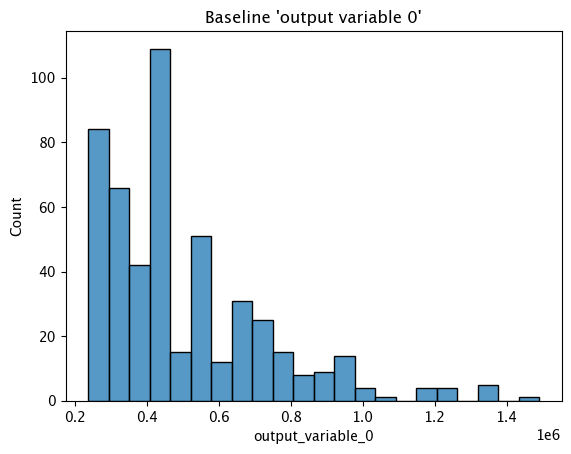

In [15]:
# get the assay builder histogram
assay_builder_from_dates.baseline_histogram()

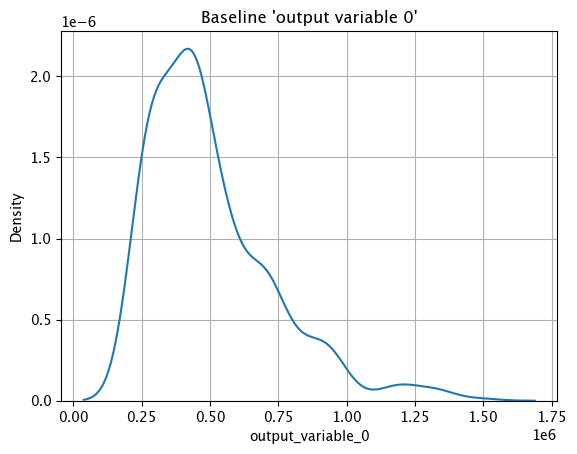

In [16]:
# get the assay builder kde chart
assay_builder_from_dates.baseline_kde()

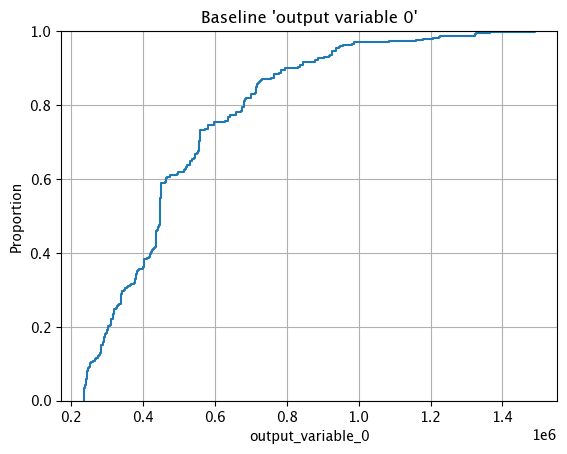

In [17]:
# get the assay builder ecdf chart
assay_builder_from_dates.baseline_ecdf()

In [18]:
# get the baseline data by date
assay_builder_from_dates.baseline_dataframe()

,time,metadata,input_tensor_0,input_tensor_1,input_tensor_2,input_tensor_3,input_tensor_4,input_tensor_5,input_tensor_6,input_tensor_7,...,input_tensor_9,input_tensor_10,input_tensor_11,input_tensor_12,input_tensor_13,input_tensor_14,input_tensor_15,input_tensor_16,input_tensor_17,output_variable_0
0,1702403410655,"{'last_model': '{""model_name"":""housepricesagacontrol"",""model_sha"":""e22a0831aafd9917f3cc87a15ed267797f80e2afa12ad7d8810ca58f173b8cc6""}', 'pipeline_version': 'aa5fe3e1-9df9-475c-9f89-76b6f3be319d', 'elapsed': [1588264, 1901377], 'dropped': [], 'partition': 'engine-578bcb6c74-vl9dd'}",3.0,2.50,1660.0,10763.0,2.0,0.0,0.0,3.0,...,1660.0,0.0,47.381199,-122.028999,2010.0,7983.0,20.0,0.0,0.0,284845.343750
1,1702403410655,"{'last_model': '{""model_name"":""housepricesagacontrol"",""model_sha"":""e22a0831aafd9917f3cc87a15ed267797f80e2afa12ad7d8810ca58f173b8cc6""}', 'pipeline_version': 'aa5fe3e1-9df9-475c-9f89-76b6f3be319d', 'elapsed': [1588264, 1901377], 'dropped': [], 'partition': 'engine-578bcb6c74-vl9dd'}",2.0,1.00,1410.0,5000.0,1.0,0.0,2.0,4.0,...,940.0,470.0,47.553101,-122.378998,1450.0,5000.0,97.0,0.0,0.0,437929.843750
2,1702403410655,"{'last_model': '{""model_name"":""housepricesagacontrol"",""model_sha"":""e22a0831aafd9917f3cc87a15ed267797f80e2afa12ad7d8810ca58f173b8cc6""}', 'pipeline_version': 'aa5fe3e1-9df9-475c-9f89-76b6f3be319d', 'elapsed': [1588264, 1901377], 'dropped': [], 'partition': 'engine-578bcb6c74-vl9dd'}",3.0,1.75,1610.0,14000.0,1.0,0.0,0.0,4.0,...,1050.0,560.0,47.342899,-122.036003,1550.0,10080.0,38.0,0.0,0.0,276709.062500
3,1702403410655,"{'last_model': '{""model_name"":""housepricesagacontrol"",""model_sha"":""e22a0831aafd9917f3cc87a15ed267797f80e2afa12ad7d8810ca58f173b8cc6""}', 'pipeline_version': 'aa5fe3e1-9df9-475c-9f89-76b6f3be319d', 'elapsed': [1588264, 1901377], 'dropped': [], 'partition': 'engine-578bcb6c74-vl9dd'}",3.0,2.50,2370.0,4200.0,2.0,0.0,0.0,3.0,...,2370.0,0.0,47.369900,-122.018997,2370.0,4370.0,1.0,0.0,0.0,349102.750000
4,1702403410655,"{'last_model': '{""model_name"":""housepricesagacontrol"",""model_sha"":""e22a0831aafd9917f3cc87a15ed267797f80e2afa12ad7d8810ca58f173b8cc6""}', 'pipeline_version': 'aa5fe3e1-9df9-475c-9f89-76b6f3be319d', 'elapsed': [1588264, 1901377], 'dropped': [], 'partition': 'engine-578bcb6c74-vl9dd'}",4.0,1.50,1760.0,6150.0,1.5,0.0,0.0,3.0,...,1760.0,0.0,47.387100,-122.223999,1760.0,8276.0,63.0,0.0,0.0,289684.218750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1702403410655,"{'last_model': '{""model_name"":""housepricesagacontrol"",""model_sha"":""e22a0831aafd9917f3cc87a15ed267797f80e2afa12ad7d8810ca58f173b8cc6""}', 'pipeline_version': 'aa5fe3e1-9df9-475c-9f89-76b6f3be319d', 'elapsed': [1588264, 1901377], 'dropped': [], 'partition': 'engine-578bcb6c74-vl9dd'}",3.0,2.50,2230.0,3939.0,2.0,0.0,0.0,3.0,...,2230.0,0.0,47.730000,-122.334999,2230.0,4200.0,1.0,0.0,0.0,519346.937500
496,1702403410655,"{'last_model': '{""model_name"":""housepricesagacontrol"",""model_sha"":""e22a0831aafd9917f3cc87a15ed267797f80e2afa12ad7d8810ca58f173b8cc6""}', 'pipeline_version': 'aa5fe3e1-9df9-475c-9f89-76b6f3be319d', 'elapsed': [1588264, 1901377], 'dropped': [], 'partition': 'engine-578bcb6c74-vl9dd'}",3.0,1.75,2350.0,20820.0,1.0,0.0,0.0,4.0,...,1800.0,550.0,47.609501,-122.058998,2040.0,10800.0,36.0,0.0,0.0,700294.250000
497,1702403410655,"{'last_model': '{""model_name"":""housepricesagacontrol"",""model_sha"":""e22a0831aafd9917f3cc87a15ed267797f80e2afa12ad7d8810ca58f173b8cc6""}', 'pipeline_version': 'aa5fe3e1-9df9-475c-9f89-76b6f3be319d', 'elapsed': [1588264, 1901377], 'dropped': [], 'partition': 'engine-578bcb6c74-vl9dd'}",4.0,1.00,2000.0,4800.0,2.0,0.0,0.0,4.0,...,2000.0,0.0,47.658298,-122.350998,1260.0,1452.0,104.0,0.0,0.0,581002.937500
498,1702403410655,"{'last_model': '{""model_name"":""housepricesagacontrol"",""model_sha"":""e22a0831aafd9917f3cc87a15ed267797f80e2afa12ad7d8810ca58f173b8cc6""}', 'pipeline_version': 'aa5fe3e1-9df9

In [19]:
# get the length - should be 1 since this is just an interactive run
len(assay_analysis_from_dates)

1

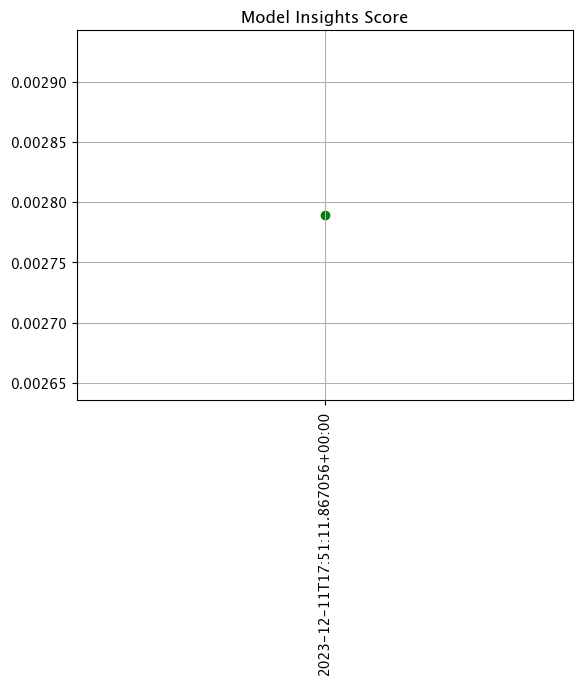

In [20]:
# chart the scores from the interactive run
assay_analysis_from_dates.chart_scores()

In [21]:
# get the dataframe from the interative run
assay_analysis_from_dates.to_dataframe()

,assay_id,name,iopath,score,start,min,max,mean,median,std,warning_threshold,alert_threshold,status
0,None,,,0.002789,2023-12-11T17:51:11.867056+00:00,236238.671875,1514079.375,503988.7406,448627.8125,232517.405053,None,0.25,Ok


In [22]:
# get the baseline from the interactive run
assay_analysis_from_dates[0].baseline_stats()

,Baseline
count,500
min,236238.671875
max,1489624.25
mean,501540.509437
median,448627.8125
std,228347.164765
start,None
end,None


In [23]:
# get the baseline bins
assay_analysis_from_dates[0].baseline_bins()

,b_edges,b_edge_names,b_aggregated_values,b_aggregation
0,2.362387e+05,left_outlier,0.000,Density
1,3.030022e+05,q_20,0.200,Density
2,4.233827e+05,q_40,0.202,Density
3,4.640602e+05,q_60,0.200,Density
4,6.822846e+05,q_80,0.208,Density
5,1.489624e+06,q_100,0.190,Density
6,inf,right_outlier,0.000,Density


baseline mean = 501540.5094375
window mean = 503988.7406000996
baseline median = 448627.8125
window median = 448627.8125
bin_mode = Quantile
aggregation = Density
metric = PSI
weighted = False
score = 0.0027890661044506705
scores = [0.0, 3.180893441862684e-06, 3.212702376281324e-06, 3.180893441862684e-06, 3.3081291795368383e-06, 8.002296276115313e-06, 0.002768181189735012]
index = None


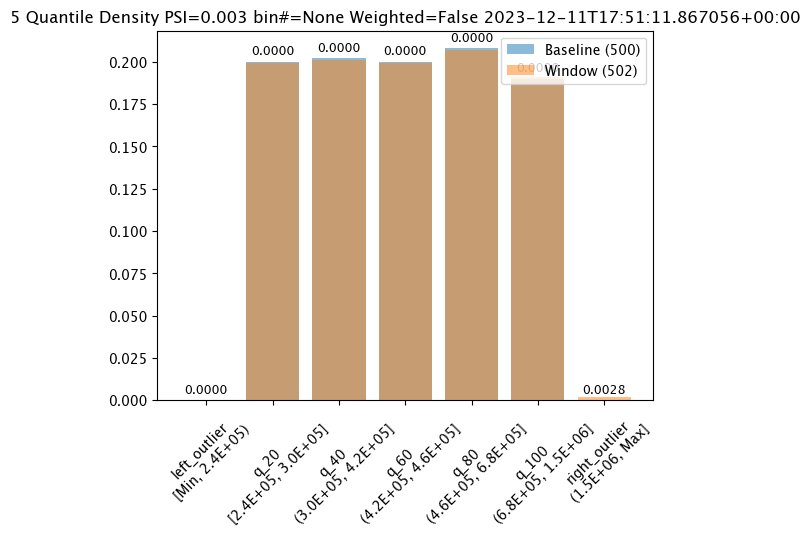

In [24]:
# get the chart with bins, values
assay_analysis_from_dates[0].chart()

In [25]:
# simple dataframe to show baseline vs window
assay_analysis_from_dates[0].compare_basic_stats()

,Baseline,Window,diff,pct_diff
count,500.0,502.0,2.000000,0.400000
min,236238.671875,236238.671875,0.000000,0.000000
max,1489624.25,1514079.375,24455.125000,1.641698
mean,501540.509437,503988.7406,2448.231163,0.488142
median,448627.8125,448627.8125,0.000000,0.000000
std,228347.164765,232517.405053,4170.240288,1.826272
start,None,2023-12-11T17:51:11.867056+00:00,NaN,NaN
end,None,2023-12-12T17:51:11.867056+00:00,NaN,NaN


In [26]:
# Compare the bins
assay_analysis_from_dates[0].compare_bins()

,b_edges,b_edge_names,b_aggregated_values,b_aggregation,w_edges,w_edge_names,w_aggregated_values,w_aggregation,diff_in_pcts
0,2.362387e+05,left_outlier,0.000,Density,2.362387e+05,left_outlier,0.000000,Density,0.000000
1,3.030022e+05,q_20,0.200,Density,3.030022e+05,e_3.03e5,0.199203,Density,-0.000797
2,4.233827e+05,q_40,0.202,Density,4.233827e+05,e_4.23e5,0.201195,Density,-0.000805
3,4.640602e+05,q_60,0.200,Density,4.640602e+05,e_4.64e5,0.199203,Density,-0.000797
4,6.822846e+05,q_80,0.208,Density,6.822846e+05,e_6.82e5,0.207171,Density,-0.000829
5,1.489624e+06,q_100,0.190,Density,1.489624e+06,e_1.49e6,0.191235,Density,0.001235
6,NaN,right_outlier,0.000,Density,NaN,right_outlier,0.001992,Density,0.001992


In [27]:
# get the numpy values

# set the results to a non-array value
small_results_baseline_df = small_results.copy()
small_results_baseline_df['variable']=small_results['out.variable'].map(lambda x: x[0])
small_results_baseline_df

,time,in.tensor,out.variable,check_failures,variable
0,2023-12-12 17:50:10.655,"[3.0, 2.5, 1660.0, 10763.0, 2.0, 0.0, 0.0, 3.0, 7.0, 1660.0, 0.0, 47.3811988831, -122.0289993286, 2010.0, 7983.0, 20.0, 0.0, 0.0]",[284845.34],0,284845.34
1,2023-12-12 17:50:10.655,"[2.0, 1.0, 1410.0, 5000.0, 1.0, 0.0, 2.0, 4.0, 7.0, 940.0, 470.0, 47.5531005859, -122.3789978027, 1450.0, 5000.0, 97.0, 0.0, 0.0]",[437929.84],0,437929.84
2,2023-12-12 17:50:10.655,"[3.0, 1.75, 1610.0, 14000.0, 1.0, 0.0, 0.0, 4.0, 7.0, 1050.0, 560.0, 47.3428993225, -122.0360031128, 1550.0, 10080.0, 38.0, 0.0, 0.0]",[276709.06],0,276709.06
3,2023-12-12 17:50:10.655,"[3.0, 2.5, 2370.0, 4200.0, 2.0, 0.0, 0.0, 3.0, 8.0, 2370.0, 0.0, 47.3698997498, -122.0189971924, 2370.0, 4370.0, 1.0, 0.0, 0.0]",[349102.75],0,349102.75
4,2023-12-12 17:50:10.655,"[4.0, 1.5, 1760.0, 6150.0, 1.5, 0.0, 0.0, 3.0, 7.0, 1760.0, 0.0, 47.3871002197, -122.2239990234, 1760.0, 8276.0, 63.0, 0.0, 0.0]",[289684.22],0,289684.22
...,...,...,...,...,...
495,2023-12-12 17:50:10.655,"[3.0, 2.5, 2230.0, 3939.0, 2.0, 0.0, 0.0, 3.0, 8.0, 2230.0, 0.0, 47.7299995422, -122.3349990845, 2230.0, 4200.0, 1.0, 0.0, 0.0]",[519346.94],0,519346.94
496,2023-12-12 17:50:10.655,"[3.0, 1.75, 2350.0, 20820.0, 1.0, 0.0, 0.0, 4.0, 8.0, 1800.0, 550.0, 47.609500885, -122.0589981079, 2040.0, 10800.0, 36.0, 0.0, 0.0]",[700294.25],0,700294.25
497,2023-12-12 17:50:10.655,"[4.0, 1.0, 2000.0, 4800.0, 2.0, 0.0, 0.0, 4.0, 7.0, 2000.0, 0.0, 47.6582984924, -122.3509979248, 1260.0, 1452.0, 104.0, 0.0, 0.0]",[581002.94],0,581002.94
498,2023-12-12 17:50:10.655,"[2.0, 0.75, 900.0, 3527.0, 1.0, 0.0, 0.0, 3.0, 6.0, 900.0, 0.0, 47.5083007812, -122.3359985352, 1220.0, 4080.0, 76.0, 0.0, 0.0]",[236815.8],0,236815.80


In [28]:
# get the numpy values
small_results_baseline = small_results_baseline_df['variable'].to_numpy()
small_results_baseline

array([ 284845.34,  437929.84,  276709.06,  349102.75,  289684.22,
        442856.4 ,  523576.2 ,  296494.97,  675545.44, 1178313.9 ,
        296411.7 ,  288798.1 ,  317132.63,  340764.53,  628260.9 ,
        341649.34,  359947.78,  779810.06,  300446.66,  437177.97,
        355371.1 ,  713979.  ,  441512.72,  552992.06,  313096.  ,
        553463.25,  241809.88,  400561.2 ,  365436.22,  530288.94,
        559631.06,  450928.94,  784103.56,  310992.94,  246901.14,
        437177.97,  451058.3 ,  879092.9 ,  461279.1 ,  795841.06,
        380009.28,  686890.94,  732735.94,  680620.7 ,  404676.1 ,
        448627.8 ,  244566.39, 1325960.8 ,  559631.06,  381737.6 ,
        424966.6 ,  718445.7 ,  689450.3 ,  283759.94, 1178313.9 ,
        437177.97,  559631.06,  559631.06,  450867.7 , 1227073.8 ,
        448627.8 ,  464060.2 ,  447162.84,  557391.25,  342604.47,
        581002.94,  467484.3 ,  544392.06,  317132.63,  758714.3 ,
        246901.14,  281058.75,  284845.34,  879092.9 , 1160512

In [39]:
assay_baseline_from_numpy_name = "assays from numpy"

# assay builder by baseline
assay_builder_from_numpy = wl.build_assay(assay_name=assay_baseline_from_numpy_name, 
                               pipeline=mainpipeline, 
                               model_name=model_name_control, 
                               iopath="output variable 0", 
                               baseline_data = small_results_baseline)

In [43]:
# set the width
assay_builder_from_numpy.window_builder().add_width(minutes=1)
assay_builder_from_numpy.window_builder().add_start(assay_baseline_start)

In [44]:
assay_config_from_numpy = assay_builder_from_numpy.build()

In [45]:
assay_analysis_from_numpy = assay_config_from_numpy.interactive_run()

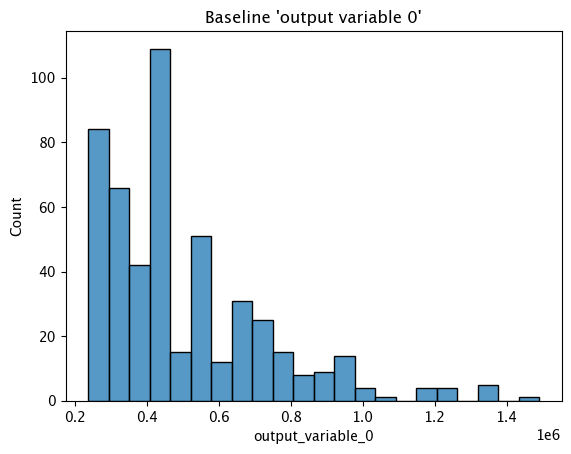

In [46]:
# get the histogram from the numpy baseline
assay_builder_from_numpy.baseline_histogram()

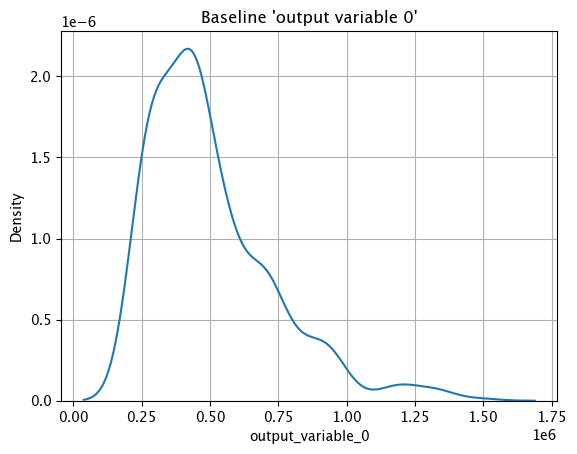

In [47]:
# get the numpy baseline kde chart
assay_builder_from_numpy.baseline_kde()

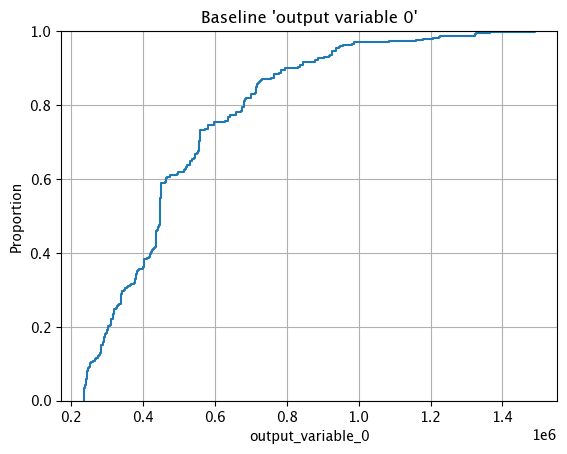

In [48]:
# get the numpy baseline ecdf chart
assay_builder_from_numpy.baseline_ecdf()

In [49]:
# get the numpy baseline ecdf chart
assay_builder_from_numpy.baseline_dataframe()

,output_variable_0
0,284845.34
1,437929.84
2,276709.06
3,349102.75
4,289684.22
...,...
495,519346.94
496,700294.25
497,581002.94
498,236815.80


In [50]:
assay_analysis_from_numpy[0].baseline_stats()

,Baseline
count,500
min,236238.67
max,1489624.3
mean,501540.51102
median,448627.8
std,228347.167822
start,None
end,None


In [51]:
assay_analysis_from_numpy[0].baseline_bins()

,b_edges,b_edge_names,b_aggregated_values,b_aggregation
0,236238.67,left_outlier,0.000,Density
1,303002.25,q_20,0.200,Density
2,423382.72,q_40,0.202,Density
3,464060.20,q_60,0.200,Density
4,682284.56,q_80,0.208,Density
5,1489624.30,q_100,0.190,Density
6,inf,right_outlier,0.000,Density


baseline mean = 501540.51102
window mean = 501540.5094375
baseline median = 448627.8
window median = 448627.8125
bin_mode = Quantile
aggregation = Density
metric = PSI
weighted = False
score = 0.0014480045485382306
scores = [0.0, 0.0, 0.0, 0.0, 0.0007130810456496068, 0.0007349235028886238, 0.0]
index = None


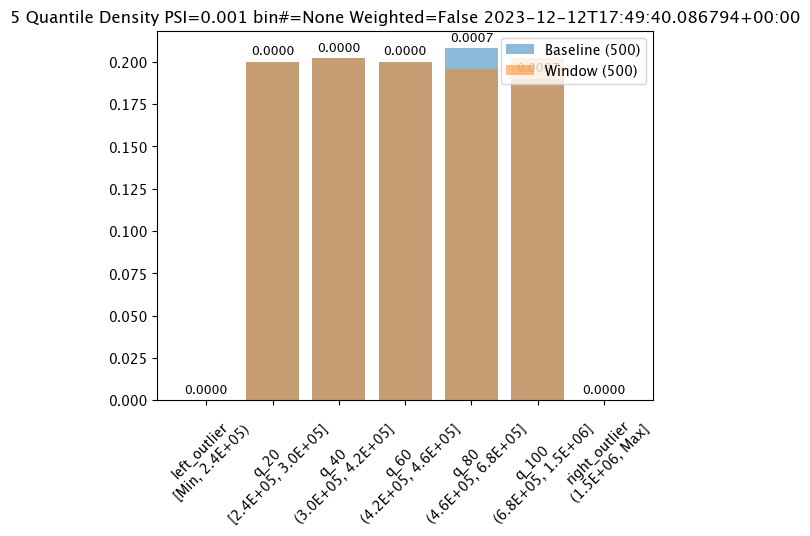

In [52]:
assay_analysis_from_numpy[0].chart()

In [53]:
assay_analysis_from_numpy[0].compare_basic_stats()

,Baseline,Window,diff,pct_diff
count,500.0,500.0,0.000000,0.000000e+00
min,236238.67,236238.671875,0.001875,7.936889e-07
max,1489624.3,1489624.25,-0.050000,-3.356551e-06
mean,501540.51102,501540.509437,-0.001583,-3.155279e-07
median,448627.8,448627.8125,0.012500,2.786274e-06
std,228347.167822,228347.164765,-0.003056,-1.338502e-06
start,None,2023-12-12T17:49:40.086794+00:00,NaN,NaN
end,None,2023-12-12T17:50:40.086794+00:00,NaN,NaN


In [54]:
assay_analysis_from_numpy[0].compare_bins()

,b_edges,b_edge_names,b_aggregated_values,b_aggregation,w_edges,w_edge_names,w_aggregated_values,w_aggregation,diff_in_pcts
0,236238.67,left_outlier,0.000,Density,236238.67,left_outlier,0.000,Density,0.000
1,303002.25,q_20,0.200,Density,303002.25,e_3.03e5,0.200,Density,0.000
2,423382.72,q_40,0.202,Density,423382.72,e_4.23e5,0.202,Density,0.000
3,464060.20,q_60,0.200,Density,464060.20,e_4.64e5,0.200,Density,0.000
4,682284.56,q_80,0.208,Density,682284.56,e_6.82e5,0.196,Density,-0.012
5,1489624.30,q_100,0.190,Density,1489624.30,e_1.49e6,0.202,Density,0.012
6,NaN,right_outlier,0.000,Density,NaN,right_outlier,0.000,Density,0.000


### Assay Testing

Now we'll perform some inferences with a spread of values, then a larger set with a set of larger house values to trigger our assay alert.  We'll use our assay created from the numpy baseline values to demonstrate.

Because our assay windows are 1 minutes, we'll need to stagger our inference values to be set into the proper windows.  This will take about 4 minutes.

In [56]:
# Get a spread of house values

# Set the start for our assay window period.
assay_window_start = datetime.datetime.now()

time.sleep(35)
# regular_houses_inputs = pd.read_json('./data/xtest-1k.df.json', orient="records")
inference_size = 1000

# regular_houses = regular_houses_inputs.sample(inference_size, replace=True).reset_index(drop=True)

# And a spread of large house values

big_houses_inputs = pd.read_json('./data/biginputs.df.json', orient="records")
big_houses = big_houses_inputs.sample(inference_size, replace=True).reset_index(drop=True)



mainpipeline.infer(big_houses)


# End our assay window period
assay_window_end = datetime.datetime.now()

In [59]:
assay_builder_from_numpy.add_run_until(assay_window_end)
assay_builder_from_numpy.window_builder().add_width(minutes=1).add_interval(minutes=1).add_start(assay_window_start)
assay_config_from_dates = assay_builder_from_numpy.build()
assay_analysis_from_numpy = assay_config_from_numpy.interactive_run()

Generated 2 analyses


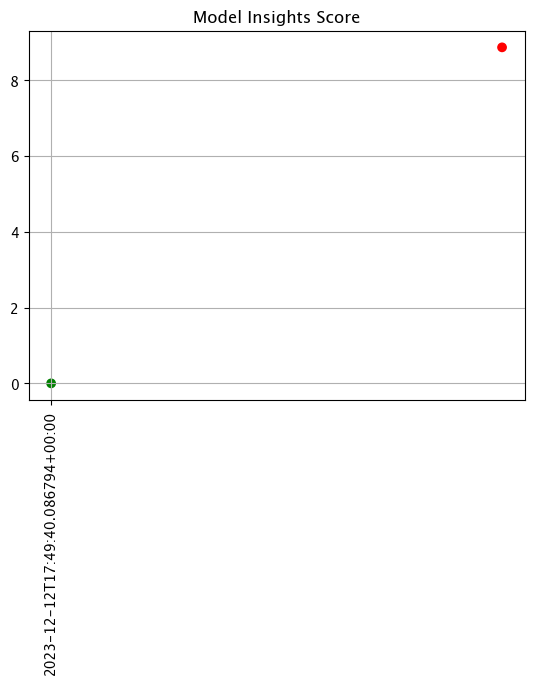

In [60]:
# Show how many assay windows were analyzed, then show the chart
print(f"Generated {len(assay_analysis_from_numpy)} analyses")
assay_analysis_from_numpy.chart_scores()

In [61]:
# Display the results as a DataFrame - we're mainly interested in the score and whether the 
# alert threshold was triggered
display(assay_analysis_from_numpy.to_dataframe().loc[:, ["score", "start", "alert_threshold", "status"]])

,score,start,alert_threshold,status
0,0.001448,2023-12-12T17:49:40.086794+00:00,0.25,Ok
1,8.868916,2023-12-12T17:58:40.086794+00:00,0.25,Alert


### Upload Assay

With the assay created and fully tested, we will upload it to the Wallaroo instance.  This will make it available for future demonstrations and visible through the Wallaroo UI.

In [62]:
assay_builder_from_numpy.upload()

22

The assay is now visible through the Wallaroo UI by selecting the workspace, then the pipeline, then **Insights**.

![Sample assay in the UI](./images/housepricesaga-sample-assay.png)

### Undeploy Main Pipeline

With the examples and tutorial complete, we will undeploy the main pipeline and return the resources back to the Wallaroo instance.

In [63]:
mainpipeline.undeploy()

name,housepricesagapipeline
created,2023-12-12 17:49:26.835126+00:00
last_updated,2023-12-12 17:49:27.771849+00:00
deployed,False
arch,None
tags,
versions,"aa5fe3e1-9df9-475c-9f89-76b6f3be319d, 70b83e32-034a-4f28-97d7-af409a05be21"
steps,housepricesagacontrol
published,False
